In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from snsphd import viz
import math
import orjson
Colors, pallet = viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6, svg_mode=True)

from enum import Enum
from dataclasses import dataclass, fields, field, _MISSING_TYPE 

from load_schema import Decode, Result

import matplotlib as mpl
import os

# set the DPI for all figures
mpl.rcParams['figure.dpi'] = 100

from snsphd.layout import bisect

from numba import njit
from snsphd.viz import save_bokeh_dark_json

In [2]:
with open("../inter/decode_20GHz26.0.json", "r") as f:
    data = orjson.loads(f.read())
    decode = Decode(**data)

db_values = np.arange(16,50, 2).tolist()
print(db_values)

# need type hints for intellisense to work
def decode_from_folder(folder_path: str, db_values: list[int]) -> list[Decode]:
    decodes = []
    for db in db_values:
        filename = f"decode_20GHz{db}.0.json"
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = orjson.loads(f.read())
            decode = Decode(**data)
            decodes.append(decode)
    return decodes

decodes = decode_from_folder("../inter", db_values)

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


In [3]:
@njit
def gaussian_2d(x, y, cov, pos=(0, 0)):
    """Generate a 2D Gaussian distribution with a given covariance matrix and position."""
    # Unpack the position tuple
    x0, y0 = pos

    # Shift the coordinates by x0 and y0
    x = x - x0
    y = y - y0

    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the determinant of the covariance matrix
    det_cov = np.linalg.det(cov)

    # Calculate the exponent term of the Gaussian function
    exponent = -0.5 * (
        inv_cov[0, 0] * x**2
        + (inv_cov[0, 1] + inv_cov[1, 0]) * x * y
        + inv_cov[1, 1] * y**2
    )

    # Calculate the normalization constant of the Gaussian function
    norm_const = 1 / (2 * np.pi * np.sqrt(det_cov))

    # Calculate the Gaussian function values
    gauss = norm_const * np.exp(exponent)

    return gauss


# @njit
def find_gm_prob_for_offset(
    x,
    y,
    existing_z,
    offset_idx,
    gm_means,
    gm_covar,
    gm_weights,
):
    """given the gaussian mixture model for the distribution of counts
    at a given offset index, find the probability of the count originating
    from the time slot with this offset. The offset index is a number of
    bins, (probably 50 ps wide)
    """
    # x = xy[0]
    # y = xy[1]
    # z = 0

    offset = offset_idx

    for pos, covar, w in zip(gm_means, gm_covar, gm_weights):
        existing_z = existing_z + gaussian_2d(x, y, covar, [pos[0] + offset*50, pos[1]+ offset*50]) * w

    return existing_z

number of components: 11
(1999, 1999)


(-200.0, 200.0)

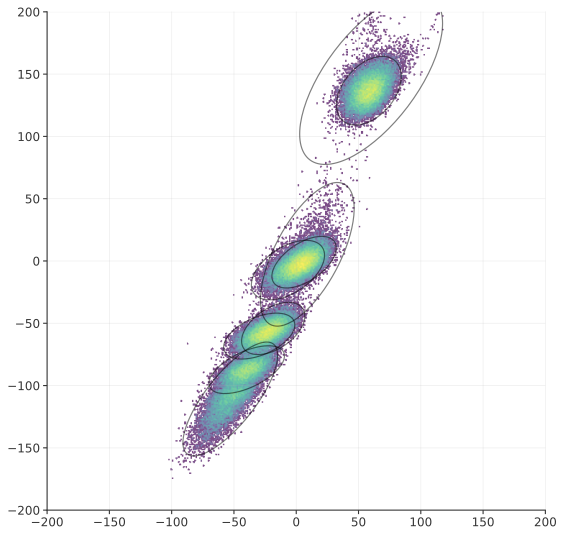

In [4]:
from matplotlib.patches import Ellipse
from load_schema import GMData
import copy
import matplotlib

def draw_ellipse(position, covariance, ax=None, single_ellipse=False, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    if single_ellipse:
        nsig = 3
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                angle=angle, fill=False, edgecolor='black', **kwargs))
    else:
        for nsig in np.linspace(0,4, 8):
            ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                angle=angle, fill=False, edgecolor='black', **kwargs))
        
    
        

def plot_gmm(ax, gm_data: GMData, label=True, data_alpha=0.2, single_ellipse=False, **ellipse_kwargs):

    w_factor = 0.2 / gm_data.weights.max()
    for pos, covar, w in zip(gm_data.means, gm_data.covariances, gm_data.weights):
        draw_ellipse(pos, covar, ax=ax, single_ellipse=single_ellipse, **ellipse_kwargs)



dB_idx = 5
components_idx = 3



x = decodes[dB_idx].hist_data.counts[:,0]
y = decodes[dB_idx].hist_data.counts[:,1]
bins = decodes[dB_idx].hist_data.bins


# print(gm_data_current)

fig, ax = plt.subplots(1,1, figsize=(9,9))


hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
# Create a grid of x and y coordinates
x_grid, y_grid = np.meshgrid(x_edges[:-1], y_edges[:-1])

# Calculate the center of mass
y_com = np.sum(x_grid * hist) / np.sum(hist)
x_com = np.sum(y_grid * hist) / np.sum(hist)

gm_data_current = copy.deepcopy(decodes[dB_idx].gm_data.gm_list[components_idx])


print(f"number of components: {gm_data_current.num_components}")

gm_data_current.means[:,0] -= x_com
gm_data_current.means[:,1] -= y_com


plot_gmm(ax, gm_data_current, single_ellipse=True, lw=1.2, alpha=0.5)
print(np.shape(hist))

# _ = ax.hist2d(x-x_com, y-y_com, bins=bins, norm=matplotlib.colors.LogNorm(), alpha=0.5, density=True, rasterized=True)

hist, xbins, ybins = np.histogram2d(x-x_com, y-y_com, bins=bins, density=False)
hist = hist - 0.15
norm = matplotlib.colors.LogNorm()
ax.imshow(hist.T, origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='viridis', norm=norm, alpha=0.7, rasterized=True)


ax.set_ylim(-200, 200)
ax.set_xlim(-200, 200)

c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pos' of function 'gaussian_2d'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_12872\1674376179.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[0.001  0.1675 0.334  0.5005 0.667  0.8335 1.    ]


(-70.0, 110.0)

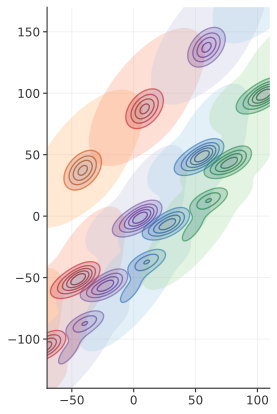

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# I want to crop the xbins and ybins


xx, yy = np.meshgrid(xbins[:-1], ybins[:-1])

y_start = -140
y_end = 170
x_start = -70
x_end = 110

aspect_ratio = (y_end - y_start)/(x_end - x_start)


fig, ax = plt.subplots(1,1, figsize=(4,aspect_ratio*4))


res_0 = find_gm_prob_for_offset(xx, yy, 0, -2, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)
res_1 = find_gm_prob_for_offset(xx, yy, 0, -1, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)
res_2 = find_gm_prob_for_offset(xx, yy, 0, 0, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)
res_3 = find_gm_prob_for_offset(xx, yy, 0, 1, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)
res_4 = find_gm_prob_for_offset(xx, yy, 0, 2, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)

res_0 = res_0/np.max(res_0)
res_1 = res_1/np.max(res_1)
res_2 = res_2/np.max(res_2)
res_3 = res_3/np.max(res_3)
res_4 = res_4/np.max(res_4)




norm = matplotlib.colors.LogNorm(vmin=.001*np.max(res_2), vmax=1)
# plt.imshow(res.T, origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='viridis', norm=norm, alpha=0.7, rasterized=True)
levels = np.linspace(0.001, 1, 7)
print(levels)

ax.contour(res_0, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Oranges', norm=norm, alpha=0.6, levels=levels[1:], linewidths=1.3)
ax.contour(res_1, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Reds', norm=norm, alpha=0.6, levels=levels[1:], linewidths=1.3)
ax.contour(res_2, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Purples', norm=norm, alpha=0.6, levels=levels[1:], linewidths=1.3)
ax.contour(res_3, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Blues', norm=norm, alpha=0.6, levels=levels[1:], linewidths=1.3)
ax.contour(res_4, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Greens', norm=norm, alpha=0.6, levels=levels[1:], linewidths=1.3)

ax.contourf(res_0, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Oranges', norm=norm, alpha=0.3, levels=levels)
ax.contourf(res_1, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Reds', norm=norm, alpha=0.3, levels=levels)
ax.contourf(res_2, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Purples', norm=norm, alpha=0.3, levels=levels)
ax.contourf(res_3, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Blues', norm=norm, alpha=0.3, levels=levels)
ax.contourf(res_4, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='Greens', norm=norm, alpha=0.3, levels=levels)
# ax.imshow(hist.T/np.max(hist.T), origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='viridis', norm=norm, alpha=0.7, rasterized=True)

ax.set_ylim(y_start, y_end)
ax.set_xlim(x_start, x_end)

measure: -50


(-200.0, 200.0)

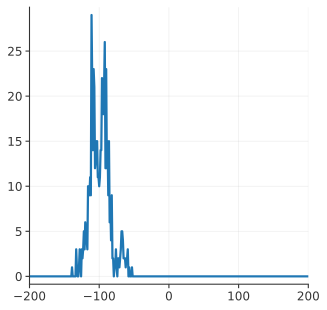

In [6]:
hist_for_slice, bins_x_for_slice, bins_y_for_slice = np.histogram2d(x-x_com, y-y_com, bins=bins)

hist_for_slice[50]

fig,ax = plt.subplots(1,1, figsize=(5,5))
    

dx = 950
ax.plot(bins_y_for_slice[:-1], hist_for_slice[dx,:])
print(f"measure: {bins_x_for_slice[dx]}")
ax.set_xlim(-200,200)


In [7]:

from numpy.random import standard_normal

from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
# from bokeh.transform import linear_cmap
# from bokeh.util.hex import hexbin
# from bokeh.models import LogColorMapper
from bokeh.models import ColumnDataSource, Rect
# from bokeh.palettes import Sunset8
# from bokeh.colors import RGB
from bokeh.models import WheelZoomTool, PanTool
from bokeh.layouts import column, row

from bokeh.plotting import figure, output_file, show
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.models.widgets import Slider
from bokeh.models.dom import Div, Styles
from bokeh.models import Legend
import numpy as np


# output_notebook()

crop_start = 800
crop_end = 1200

hist_sm = np.abs(np.copy(5000*hist/np.max(hist))).astype(np.uint16)[crop_start:crop_end, crop_start:crop_end]

res_sm = np.abs(np.copy(5000*res_2/np.max(res_2))).astype(np.uint16)[crop_start:crop_end, crop_start:crop_end]


dd_1 = {"image": [hist_sm]}

dd_2 = {"x": np.arange(len(hist_sm)).astype(np.uint16),
      "y_data": np.zeros(len(hist_sm)).astype(np.uint16),
      "y_fit": np.zeros(len(hist_sm)).astype(np.uint16),}

dd_res = {"image": [res_sm.T]}

ds_1 = ColumnDataSource(dd_1)
ds_2 = ColumnDataSource(dd_2)
ds_res = ColumnDataSource(dd_res)

# create a data source for the draggable bar
y_center = np.average([dd_2["x"][0],dd_2["x"][-1]])

bar_source = ColumnDataSource(data=dict(x=[float(y_center)], y=[dd_2["x"][0]]))
img = figure( match_aspect=True, background_fill_color='#5e4fa2', height=500, width=500, tools=[]) #tools=[WheelZoomTool(), PanTool()])
img.toolbar.logo = None
img.grid.grid_line_color = None
hist_plt_linear = figure(title="", width=500,height=130, toolbar_location=None, y_axis_type='linear', tools=[])
img.image(image="image", dh=np.shape(hist_sm)[0], dw=np.shape(hist_sm)[1], x=0, y=0, source=dd_1, palette="Spectral11")
# plot the draggable bar

bar = img.rect(x='x', y='y', height=3, width=dd_2["x"][-1] - dd_2["x"][0], alpha=1, color='red', source=bar_source)

style = Styles(
    width='100%',
)


slider = Slider(start=dd_2["x"][0], end=dd_2["x"][-1], step=1, value=0, title="Draggable Range", sizing_mode="stretch_width")
hist_plt_linear.line(x="x", y="y_data", line_width=2, source=ds_2, color="#66a1ff", legend_label="Data")
hist_plt_linear.line(x="x", y="y_fit", line_width=2, source=ds_2, color='#ff6666', legend_label="GMM")

hist_plt_linear.y_range.start = 0
hist_plt_linear.y_range.end = 5000

legend = Legend()#items=[("Data", [hist_plt_linear.renderers[0]]), ("GMM", [hist_plt_linear.renderers[1]])], location="center")
hist_plt_linear.add_layout(legend, "right")

# create a custom JavaScript callback to link the x-location of the bar to the value of the slider
callback = CustomJS(args=dict(bar_source=bar_source, slider=slider, image_source = ds_1, updating_line_source = ds_2, fit_source = ds_res), code=f"""
    var ln_data = updating_line_source.data;
                    
    var data = bar_source.data;
    var image_data = image_source.data;
    var fit_image_data = fit_source.data;
    var range = slider.value;
    data['y'][0] = range;
                    
    //console.log(ln_data['y_data'])
    
    //use the range value as an index
    //line_data['y'] = line_data[range]
    //ln_data['y_data'] = image_data['image'][0][range]
    //console.log(image_data['image'][0])
    //const dimensions = [ image_data['image'].length, image_data['image'][0].length ];
    //console.log(dimensions)
    let image_width = {np.shape(hist_sm)[0]}
            
    let slc = image_data['image'][0].slice(range*image_width, range*image_width + image_width)
    let slc_fit = fit_image_data['image'][0].slice(range*image_width, range*image_width + image_width)
    //console.log(slc)
    ln_data['y_data'] = slc
    ln_data['y_fit'] = slc_fit

    console.log(slc_fit)
    
    
    updating_line_source.change.emit();
    bar_source.change.emit();
    //console.log(ln_data['y_data'])
""")

# link the slider to the JavaScript callback
slider.js_on_change('value', callback)

# col = column(children=[hist_plt_linear])
c = column(hist_plt_linear, img,slider)
layout = c
# layout = row(c, col)

save_bokeh_dark_json(layout, "pnr_gmm.json", apply=False)

# show the plot
show(layout)